In [1]:
import numpy as np
import pandas as pd
import json
import re
import copy
import pickle
from collections import Counter
import collections
from nltk.stem import WordNetLemmatizer
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from fuzzywuzzy import fuzz
from ipywidgets import interact
import itertools
import random

# Ingredient Suggestor
In this project, I will be attempting to build an ingredient suggestor. I will explore the relations between various ingredients and try to find various algorithms that can effectively reccomend ingredients I should pick up the next time I'm at the grocery store. 

For this presentation, we will be exploring recipe data to see if we can create a quick and easy ingredient recommender. We will be looking at the recipe data from kaggle.com provided Yummly.

![](https://www.kaggle.com/content/v/9da25a3f126b/kaggle/img/site-logo.png)
Recipe Data Downloaded from What's Cooking Competition from Kaggle.com: https://www.kaggle.com/c/whats-cooking
![](https://kaggle2.blob.core.windows.net/competitions/kaggle/4526/media/Yummly_logo.png)
For this, we will be using both data from train.json and test.json. A data_combined list is created to hold all the json objects used as input.

In [2]:
data_combined = []

f = open('/data/BobbyDobo/test.json') 
data = json.load(f)
[data_combined.append(x) for x in data]
f.close()

f = open('/data/BobbyDobo/train.json')
data2 = json.load(f)
[data_combined.append(x) for x in data2]
f.close()

df = pd.read_json('/data/BobbyDobo/test.json')
df2 = pd.read_json('/data/BobbyDobo/train.json')

## Data Cleaning
We will be looking at the data provided by Yummly. As we can see, the data has features of recipe_id, cuisine, and ingredients.

### Original Data

In [1]:
data

NameError: name 'head' is not defined

In [4]:
print(df.count())
df.head(5)

id             9944
ingredients    9944
dtype: int64


id                                        ingredients
0  18009  [baking powder, eggs, all-purpose flour, raisi...
1  28583  [sugar, egg yolks, corn starch, cream of tarta...
2  41580  [sausage links, fennel bulb, fronds, olive oil...
3  29752  [meat cuts, file powder, smoked sausage, okra,...
4  35687  [ground black pepper, salt, sausage casings, l...

In [5]:
print(df2.count())
df2.head(5)

cuisine        39774
id             39774
ingredients    39774
dtype: int64


cuisine     id                                        ingredients
0        greek  10259  [romaine lettuce, black olives, grape tomatoes...
1  southern_us  25693  [plain flour, ground pepper, salt, tomatoes, g...
2     filipino  20130  [eggs, pepper, salt, mayonaise, cooking oil, g...
3       indian  22213                [water, vegetable oil, wheat, salt]
4       indian  13162  [black pepper, shallots, cornflour, cayenne pe...

### Cuisine data
I wanted to look at cuisine data to see if if there is ingredient skewness in the data.

In [6]:
cuisine = df2.groupby('cuisine').count()
cuisine = cuisine.drop('ingredients', 1)
cuisine.columns = ['count']
cuisine = cuisine.sort_values(['count'], ascending=False)

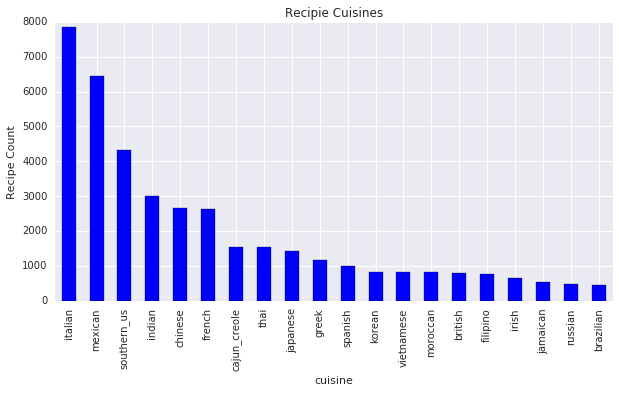

In [7]:
plt.figure(figsize=(10,5));
plt.title("Recipie Cuisines")
plt.ylabel("Recipe Count")
cuisine['count'].plot(kind='bar');

### Merged Data

In [8]:
df_merged = df.append(df2)
print(df_merged.count())
df_merged.head(3).append(df_merged.tail(3))

cuisine        39774
id             49718
ingredients    49718
dtype: int64


cuisine     id                                        ingredients
0          NaN  18009  [baking powder, eggs, all-purpose flour, raisi...
1          NaN  28583  [sugar, egg yolks, corn starch, cream of tarta...
2          NaN  41580  [sausage links, fennel bulb, fronds, olive oil...
39771    irish   2238  [eggs, citrus fruit, raisins, sourdough starte...
39772  chinese  41882  [boneless chicken skinless thigh, minced garli...
39773  mexican   2362  [green chile, jalapeno chilies, onions, ground...

In [9]:
assert df_merged['id'].dtype == 'int64'
assert df_merged['ingredients'].dtype == 'object'
assert df_merged['id'].count() == df['id'].count() + df2['id'].count()
assert df_merged['ingredients'].count() == df['ingredients'].count() + df2['ingredients'].count()
assert df_merged['cuisine'].count() == df2['cuisine'].count()
assert df_merged.isnull()['cuisine'].any() == True
assert df_merged.isnull()['id'].any() == False
assert df_merged.isnull()['ingredients'].any() == False

### Flattening the Data
I will be have to clean my data and also flatten the recipies so that I can get data on a per ingredient basis. Unfortunately there are limitations to how I can clean. Learning how to clean similar ingredients such as yogurt and yoghurt would be an entire project in itself!

In [10]:
def json_map(JSON):
    """Returns Flattened recipe Json into a list of (recipe_id, ingredient)

    Keyword arguments:
    JSON -- recipe json with keys, 'id' and 'ingredients'
    """
    lis = []
    for x in JSON:
        id = x['id']
        ingr = x['ingredients']
        for y in ingr:
            lis.append((id,y))
    return lis

def clean_item(item):
    """Cleans and returns a string by lowering, remove odd punctuation, to lemmatizing(unused).

    Keyword arguments:
    item -- string to be cleaned
    """
    item = str.lower(item)
    # http://stackoverflow.com/a/27086669/670873
    def replacing(i):
        i = i.replace('&', '').replace('(', '').replace(')','')
        i = i.replace('\'', '').replace('\\', '').replace(',','')
        i = i.replace('.', '').replace('%', '').replace('/','')
        i = i.replace('"', '')
        return i
    item = replacing(item)  
    return item

In [11]:
test_json = [{'id': 10101010, 'ingredients': ['milk','eggs','bananas']}, {'id': 10101011, 'ingredients': ['milk','cereal']}]
assert clean_item('hello&c') == 'helloc'
assert json_map(test_json) == [(10101010, 'milk'), (10101010, 'eggs'), (10101010, 'bananas'), 
                               (10101011, 'milk'), (10101011, 'cereal')]

### Below is what the data looks like after it is flattened!

In [12]:
flattened = json_map(data_combined)
flattened_clean = [ (entry[0], clean_item(entry[1])) for entry in flattened ]
print("size of data_combined", len(data_combined))
print("size of flattened", len(flattened))
print("size of flattened_cleaned:", len(flattened_clean))
flattened

size of data_combined 49718
size of flattened 535670
size of flattened_cleaned: 535670


[(18009, 'baking powder'),
 (18009, 'eggs'),
 (18009, 'all-purpose flour'),
 (18009, 'raisins'),
 (18009, 'milk'),
 (18009, 'white sugar'),
 (28583, 'sugar'),
 (28583, 'egg yolks'),
 (28583, 'corn starch'),
 (28583, 'cream of tartar'),
 (28583, 'bananas'),
 (28583, 'vanilla wafers'),
 (28583, 'milk'),
 (28583, 'vanilla extract'),
 (28583, 'toasted pecans'),
 (28583, 'egg whites'),
 (28583, 'light rum'),
 (41580, 'sausage links'),
 (41580, 'fennel bulb'),
 (41580, 'fronds'),
 (41580, 'olive oil'),
 (41580, 'cuban peppers'),
 (41580, 'onions'),
 (29752, 'meat cuts'),
 (29752, 'file powder'),
 (29752, 'smoked sausage'),
 (29752, 'okra'),
 (29752, 'shrimp'),
 (29752, 'andouille sausage'),
 (29752, 'water'),
 (29752, 'paprika'),
 (29752, 'hot sauce'),
 (29752, 'garlic cloves'),
 (29752, 'browning'),
 (29752, 'lump crab meat'),
 (29752, 'vegetable oil'),
 (29752, 'all-purpose flour'),
 (29752, 'freshly ground pepper'),
 (29752, 'flat leaf parsley'),
 (29752, 'boneless chicken skinless thigh'

# Building Ingredient Relations
We need to build a food relationship list! This is essential to seeing how often ingredients appear to each other. Unfortunately this process is O(n^2) time.

In [13]:
#https://www.kaggle.com/dipayan/whats-cooking/whatscooking-python/code
temp = df_merged
def relations(df_recipe):
    """Creates a collctions.Counter for each ingredient and returns a list of those.

    Keyword arguments:
    JSON -- recipe json with keys, 'id' and 'ingredients'
    """
    word_relations = {}
    for recipe in df_recipe['ingredients']:
        temp_recipe = copy.deepcopy(recipe)
        for item in recipe:
            temp_recipe.remove(item)
            if item in word_relations:
                word_relations[item].update(temp_recipe)
            else:
                word_relations[item] = Counter(temp_recipe)
            temp_recipe.append(item)
    return word_relations

#This contains all the relations between foods
ingredient_relations = relations(temp)

### Ingredient Relations
Below are food reltionships, there are some pretty intersting food names, and on quick inspection, we notice that there are some ingredients that should be considered the same.

In [14]:
ingredient_relations

{'uni': Counter({'agave nectar': 1,
          'bonito flakes': 1,
          'dashi kombu': 1,
          'konbu': 1,
          'light soy sauce': 1,
          'mirin': 1,
          'nama yuba': 1,
          'rice vinegar': 1,
          'sake': 1,
          'salt': 1,
          'sea salt': 1,
          'shiso': 1,
          'white pepper': 1,
          'yuzu': 1}),
 'Crisco Pure Canola Oil': Counter({'chicken broth': 1,
          'chunky peanut butter': 1,
          'couscous': 1,
          'frozen peas': 1,
          'garlic': 1,
          'green bell pepper': 1,
          'ground cumin': 1,
          'onions': 1,
          'pepper': 1,
          'salt': 1}),
 'chervil': Counter({'Belgian endive': 1,
          'Boston lettuce': 1,
          'Emmenthal': 1,
          'Italian parsley leaves': 2,
          'Vietnamese coriander': 1,
          'all-purpose flour': 3,
          'almonds': 1,
          'artichoke hearts': 1,
          'arugula': 1,
          'asiago': 1,
          'baby carr

In [15]:
test_relations = relations(temp.head(1))
test_relations2 = relations(temp.head(5))
assert sum(test_relations['all-purpose flour'].values()) == 5
assert sum(test_relations2['all-purpose flour'].values()) == 25
test_json = [{'id': 10101010, 'ingredients': ['milk', 'eggs', 'bananas', 'flour']}, 
             {'id': 10101011, 'ingredients': ['milk','cereal', 'bananas']}]
df_test_json = pd.DataFrame(test_json)
test_json_relations = relations(df_test_json)
assert test_json_relations == {'bananas': Counter({'cereal': 1, 'eggs': 1, 'flour': 1, 'milk': 2}),
 'cereal': Counter({'bananas': 1, 'milk': 1}),
 'eggs': Counter({'bananas': 1, 'flour': 1, 'milk': 1}),
 'flour': Counter({'bananas': 1, 'eggs': 1, 'milk': 1}),
 'milk': Counter({'bananas': 2, 'cereal': 1, 'eggs': 1, 'flour': 1})}

In [16]:
flattened_rec_item = flattened_clean

## Further Exploration Time!

Let's look at what are the most common ingredients and what percentage of the total ingredients they are.

In [17]:
cleaned = pd.DataFrame(flattened_rec_item, columns=["id","ingredient"])
ingredients = cleaned.groupby('ingredient')
counts = ingredients.count()
counts['per'] = counts['id']/counts['id'].sum()
counts = counts.sort_values('per', ascending = False)
counts = counts.loc[counts['per'] > 0.0005]
counts = counts.rename(columns = {'id': 'count'})
counts['rank'] = [x for x in range(1,len(counts)+1)]

In [18]:
counts.head(20)

count       per  rank
ingredient                                
salt                 22534  0.042067     1
onions               10008  0.018683     2
olive oil             9889  0.018461     3
water                 9293  0.017348     4
garlic                9171  0.017121     5
sugar                 8064  0.015054     6
garlic cloves         7772  0.014509     7
butter                6078  0.011347     8
ground black pepper   5990  0.011182     9
all-purpose flour     5816  0.010857    10
vegetable oil         5516  0.010297    11
pepper                5508  0.010282    12
eggs                  4262  0.007956    13
soy sauce             4120  0.007691    14
kosher salt           3930  0.007337    15
green onions          3817  0.007126    16
tomatoes              3812  0.007116    17
large eggs            3700  0.006907    18
carrots               3542  0.006612    19
unsalted butter       3474  0.006485    20

Here is a graph of the most common ingredients.

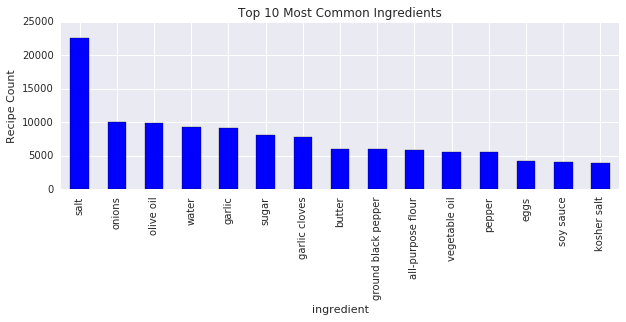

In [19]:
plt.figure(figsize=(10,3));
plt.title("Top 10 Most Common Ingredients")
plt.ylabel("Recipe Count")
plot = counts['count'].head(15).plot(kind='bar')

Let's seriously look at some of these similar values. The 5th and 7th most common ingredients are garlic and garlic cloves. We need to see how many more same ingredients are there. So let's use some fuzzy matching!

Unfortunately I don't think there is much I can do to fix the similar ingredients that's within the scope of the project. There doesn't appear to be a simple solution to fix this.

In [20]:
matches = []
for ingredient in counts.index:
    for ingredient2 in counts.index:
        ratio = fuzz.ratio(ingredient2, ingredient)
        if(ratio >= 70 and ingredient2 != ingredient):
            matches.append((ingredient, ingredient2, ratio))
relations = pd.DataFrame(matches, columns=['item1','item2','fuzz_ratio']).sort_values('fuzz_ratio', ascending=False)
relations['ranking'] = [x for x in range(1,len(relations)+1)]
relations = relations.set_index('ranking')
print('relations length:', len(relations))
relations.head(20).append(relations.tail(20))

relations length: 594


item1  \
ranking                                            
1        boneless skinless chicken breast halves   
2                                    green chile   
3              boneless skinless chicken breasts   
4                                  green chilies   
5                              green bell pepper   
6                                red bell pepper   
7                              ground red pepper   
8                                  ground pepper   
9                               red chili powder   
10                                    green peas   
11                                   green beans   
12                                  bread crumbs   
13                                  chili powder   
14                              dry bread crumbs   
15                              fresh lime juice   
16                               red bell pepper   
17                                   bell pepper   
18                             fresh lemon juice   
19                            white wine vinegar   
20                              chopped cilantro   
575                                  lemon juice   
576                                dried oregano   
577                                chicken stock   
578                              cilantro leaves   
579                                boiling water   
580                                fresh parsley   
581                              cherry tomatoes   
582                                chicken broth   
583                                chicken broth   
584                                      parsley   
585                                     cilantro   
586                                  sweet onion   
587                     low sodium chicken broth   
588                                     cilantro   
589                                   fresh dill   
590                                  green beans   
591                                   cold water   
592                                    hot sauce   
593                                 diced onions   
594                                 tomato sauce   

                                           item2  fuzz_ratio  
ranking                                                       
1              boneless skinless chicken breasts          92  
2                                  green chilies          92  
3        boneless skinless chicken breast halves          92  
4                                    green chile          92  
5                                red bell pepper          88  
6                              green bell pepper          88  
7                                  ground pepper          87  
8                              ground red pepper          87  
9                                   chili powder          86  
10                                   green beans          86  
11                                    green peas          86  
12                              dry bread crumbs          86  
13                              red chili powder          86  
14                                  bread crumbs          86  
15                             fresh lemon juice          85  
16                                   bell pepper          85  
17                               red bell pepper          85  
18                              fresh lime juice          85  
19                                 white vinegar          84  
20                        chopped cilantro fresh          84  
575                                 orange juice          70  
576                                      oregano          70  
577                                      chicken          70  
578                                     cilantro          70  
579                                   cold water          70  
580                                      parsley          70  
581                                     tomatoes          70  
582                            

Here is another way to look at the ingredient relations, using a dataframe that's similar to a vector.

In [21]:
df_ingredient_relations = pd.DataFrame(ingredient_relations)

In [22]:
df_ingredient_relations

(    oz.) tomato sauce  \
(    oz.) tomato sauce                                                 NaN   
(   oz.) tomato paste                                                    1   
(10 oz.) frozen chopped spinach                                          1   
(10 oz.) frozen chopped spinach, thawed and squ...                     NaN   
(14 oz.) sweetened condensed milk                                      NaN   
(14.5 oz.) diced tomatoes                                              NaN   
(15 oz.) refried beans                                                 NaN   
1% low-fat buttermilk                                                  NaN   
1% low-fat chocolate milk                                              NaN   
1% low-fat cottage cheese                                              NaN   
1% low-fat milk                                                        NaN   
2 1/2 to 3 lb. chicken, cut into serving pieces                        NaN   
2% low fat cheddar chees                                               NaN   
2% low-fat cottage cheese                                              NaN   
2% lowfat greek yogurt                                                 NaN   
2% milk shredded mozzarella cheese                                     NaN   
2% reduced fat chocolate milk                                          NaN   
2% reduced-fat milk                                                    NaN   
25% less sodium chicken broth                                          NaN   
33% less sodium cooked deli ham                                        NaN   
33% less sodium cooked ham                                             NaN   
33% less sodium ham                                                    NaN   
33% less sodium smoked fully cooked ham                                NaN   
33% less sodium smoked ham                                             NaN   
40% less sodium taco seasoning                                         NaN   
40% less sodium taco seasoning mix                                     NaN   
50% less sodium black beans                                            NaN   
7 Up                                                                   NaN   
8 ounc ziti pasta, cook and drain                                      NaN   
95% lean ground beef                                                   NaN   
...                                                                    ...   
yellowtail                                                             NaN   
yellowtail snapper fillets                                             NaN   
yodel                                                                  NaN   
yoghurt                                                                NaN   
yoghurt natural low fat                                                NaN   
yogurt cheese                                                          NaN   
yogurt dressing                                                        NaN   
yogurt low fat                                                         NaN   
yolk                                                                   NaN   
yoplait                                                                NaN   
young coconut meat                                                     NaN   
young ginger                                                           NaN   
young leeks                                                            NaN   
young nettle                                                           NaN   
yu choy                                                                NaN   
yuca                                                                   NaN   
yucca                                                                  NaN   
yucca root                                                             NaN   
yukon gold                                                             NaN   
yukon gold potatoes                                                    NaN

There are some pretty interesting ingredients here. The zucchini being used 13,563 times is probably an indication that the dataset is pretty scewed towards certain cuisines.

In [23]:
df_ingredient_relations_stats = pd.DataFrame(index=df_ingredient_relations.index)
df_ingredient_relations_stats['list_size'] = df_ingredient_relations.apply(np.sum, axis=1)
df_ingredient_relations_stats

list_size
(    oz.) tomato sauce                                    175
(   oz.) tomato paste                                     108
(10 oz.) frozen chopped spinach                            27
(10 oz.) frozen chopped spinach, thawed and squ...         21
(14 oz.) sweetened condensed milk                          16
(14.5 oz.) diced tomatoes                                  70
(15 oz.) refried beans                                     32
1% low-fat buttermilk                                      51
1% low-fat chocolate milk                                  11
1% low-fat cottage cheese                                 199
1% low-fat milk                                          2474
2 1/2 to 3 lb. chicken, cut into serving pieces            21
2% low fat cheddar chees                                   10
2% low-fat cottage cheese                                  90
2% lowfat greek yogurt                                     25
2% milk shredded mozzarella cheese                          8
2% reduced fat chocolate milk                               3
2% reduced-fat milk                                       817
25% less sodium chicken broth                              27
33% less sodium cooked deli ham                            16
33% less sodium cooked ham                                 15
33% less sodium ham                                        26
33% less sodium smoked fully cooked ham                     8
33% less sodium smoked ham                                 15
40% less sodium taco seasoning                             91
40% less sodium taco seasoning mix                         51
50% less sodium black beans                                 2
7 Up                                                       51
8 ounc ziti pasta, cook and drain                           9
95% lean ground beef                                       71
...                                                       ...
yellowtail                                                  5
yellowtail snapper fillets                                 20
yodel                                                       8
yoghurt                                                  4382
yoghurt natural low fat                                    25
yogurt cheese                                              15
yogurt dressing                                            16
yogurt low fat                                              2
yolk                                                      182
yoplait                                                    13
young coconut meat                                         19
young ginger                                               31
young leeks                                                 8
young nettle                                                8
yu choy                                                    35
yuca                                                       35
yucca                                                      17
yucca root                                                 14
yukon gold                                                113
yukon gold potatoes                                      2892
yuzu                                                       85
yuzu juice                                                 29
za'atar                                                    43
zabaglione                                                 18
zest                                                      246
zesty italian dressing                                    162
zinfandel                                                 123
ziti                                                      403
zucchini                                                13563
zucchini blossoms                                          14

[7137 rows x 1 columns]

## Suggestion exploration 
For suggestions we will look at:
- just combining the relation Counters and selecting the highest counts 
- converting the relation Counters to percentages then joining
- combining the relation Counters and selection a random ingredient from the weighted list

In [24]:
def combine_relations(indexes, relations):
    """Returns combined collection.Counters which do not have redundancies

    Keyword arguments:
    indexes-- columns to look at in relations Counter dictionary
    relations-- relations dictionary which includes the collections.Counters for each ingredient
    """
    combined = collections.Counter()
    for x in indexes:
        if x in relations:
            combined = combined + relations[x]
        else:
            #pass if item is not in relations table
            pass
    for x in indexes:
        if x in combined:
            del combined[x]
        else:
            #pass if item is not in combined relation
            pass
    return combined

def suggestion(combined, selected=[], n=1, ignore=None):
    """Returns a list of suggestions based on the most common item in combined paramater

    Keyword arguments:
    combined-- the combined collection.Counter used for prediction 
    selected-- list of items already used in the cart used to base predictions off of (default= empty list)
    n-- number of items to suggest (default= 1)
    ignore-- list of items to ignore and never suggest
    """
    temp_selected = copy.deepcopy(selected)
    if ignore != None:
        temp_selected = temp_selected + ignore
    drawn = []
    for x in combined.most_common():
        if x[0] in temp_selected:
            pass
        else:
            temp_selected.append(x[0])
            drawn.append(x[0])
            if len(drawn) == n:
                break
    return drawn

More tests!

In [25]:
combined = ingredient_relations['milk'] + ingredient_relations['cheese']
assert combined['milk'] != 0
combined = combine_relations(['milk','cheese'], ingredient_relations)
assert combined['milk'] == 0
assert suggestion(combined, ['salt'], 12) == \
['butter',
 'all-purpose flour',
 'eggs',
 'sugar',
 'onions',
 'large eggs',
 'baking powder',
 'water',
 'pepper',
 'unsalted butter',
 'flour',
 'olive oil']
assert suggestion(combined, ['salt'], 5, ignore=['butter','eggs']) == \
['all-purpose flour',
 'sugar',
 'onions',
 'large eggs',
 'baking powder']

#empty relations test
missing_relations = combine_relations(['pizzapieice'], ingredient_relations)
missing_relations_suggestion = suggestion(missing_relations, ['also', 'invalid'], 10)
assert missing_relations == collections.Counter()
assert missing_relations_suggestion == []
assert len(missing_relations_suggestion) == 0

#some dirty input test
dirty_relations = combine_relations(['ice_cream', 'bananas', 'toys'], ingredient_relations)
dirty_cart = ['ice_cream', 'bananas', 'toys']
dirty_suggestion = suggestion(dirty_relations, dirty_cart, 5)
assert sum(dirty_relations.values()) != 0
assert len(dirty_suggestion) == 5

In [26]:
cart_relations = combine_relations(['ice cream', 'bananas', 'toys'], ingredient_relations)
cart = ['ice_cream', 'bananas', 'toys']
print('Your cart:', cart, '\n',
      'Suggestions:', suggestion(cart_relations, cart, 5))

Your cart: ['ice_cream', 'bananas', 'toys'] 
 Suggestions: ['salt', 'sugar', 'vanilla extract', 'butter', 'all-purpose flour']


Example shopping cart with relation Counter joining. We will select the most common ingredient among combined ingredients.

In [27]:
def cart_example(add):
    """Function used to setup interact for suggestion

    Keyword arguments:
    add-- name of ingredient to add to the cart
    """
    cart = ['apple','rice']
    cart.append(add)
    print('Your cart:', cart, '\n',
      'Suggestions:', suggestion(cart_relations, cart, 10))
interact(cart_example, add='text', __manual=True);

In [28]:
def combine_relations(indexes, relations):
    """Returns combined collection.Counters which does not have redundancies

    Keyword arguments:
    indexes-- columns to look at in relations Counter dictionary
    relations-- relations dictionary which includes the collections.Counters for each ingredient
    """
    combined = collections.Counter()
    for x in indexes:
        if x in relations:
            combined = combined + relations[x]
    for x in indexes:
        if x in combined:
            del combined[x]
    return combined

def count_suggestion(combined, selected=[], n=1, ignore=None):
    """Returns a list of suggestions based on the most common items in combined paramater

    Keyword arguments:
    combined-- the combined collection.Counter used for prediction 
    selected-- list of items already used in the cart used to base predictions off of (default= empty list)
    n-- number of items to suggest (default= 1)
    ignore-- list of items to ignore and never suggest
    """
    temp_selected = copy.deepcopy(selected)
    if ignore != None:
        temp_selected = temp_selected + ignore
    drawn = []
    for x in combined.most_common():
        if x[0] in temp_selected:
            pass
        else:
            temp_selected.append(x[0])
            drawn.append(x[0])
            if len(drawn) == n:
                break
    return drawn

In [29]:
def combine_perc_relations(indexes, relations):
    """Returns combined dictionary which does not have redundancies with ingredient, additive.percentage pairings

    Keyword arguments:
    indexes-- columns to look at in relations Counter dictionary
    relations-- relations dictionary which includes the collections.Counters for each ingredient
    """
    combined = {}
    for ingredient in indexes:
        if ingredient in relations:
            ingredient_sum = sum(relations[ingredient].values())
            for item in relations[ingredient]:
                count = relations[ingredient][item]
                if item in combined:
                    combined[item] = combined[item] + count/ingredient_sum
                else:
                    combined[item] = count/ingredient_sum
    for ingredient in indexes:
        if ingredient in combined:
            del combined[ingredient]
    return combined

def perc_suggestion(combined, selected=[], n=1, ignore=None):
    """Returns a list of suggestions based on adding percentages that ingredient occured with another ingredient

    Keyword arguments:
    combined-- the combined dictionary from combine_perc_relations()
    selected-- list of items already used in the cart used to base predictions off of (default= empty list)
    n-- number of items to suggest (default= 1)
    ignore-- list of items to ignore and never suggest
    """
    temp_selected = copy.deepcopy(selected)
    drawn = []
    if ignore != None:
        temp_selected = temp_selected + ignore 
    temp_sorted = copy.deepcopy(combined)
    df = pd.DataFrame(index=temp_sorted.keys(), columns=['ingredient', 'mod.prob'])
    df['val'] = temp_sorted.values()
    df = df.sort_values(['val'], ascending=False)
    for ingredient in df.index:
        if ingredient in temp_selected:
            pass
        else:
            temp_selected.append(ingredient)
            drawn.append(ingredient)
            if len(drawn) == n:
                break
    return drawn

In [30]:
def rand_count_suggestion(combined, selected=[], n=1, ignore=None):
    """Returns a list of suggestions using random values based on weighted Counter values

    Keyword arguments:
    combined-- the combined collection.Counter used for prediction 
    selected-- list of items already used in the cart used to base predictions off of (default= empty list)
    n-- number of items to suggest (default= 1)
    ignore-- list of items to ignore and never suggest
    """
    temp_selected = copy.deepcopy(selected)
    if ignore != None:
        temp_selected = temp_selected + ignore
    drawn = []
    for x in combined:
        # Code line below created using this resource
        # http://stackoverflow.com/questions/9084647/how-can-i-get-a-weighted-random-pick-from-pythons-counter-class
        x = next(itertools.islice(combined.elements(), random.randrange(sum(combined.values())), None))
        if x in temp_selected:
            pass
        else:
            temp_selected.append(x)
            drawn.append(x)
            if len(drawn) == n:
                break
    return drawn

## Interact Widgets
Here you can interactively see how each algorithm differes in it's predictions. Note that the counter and the percentages algorithms, only have minor differences. Both would require ignore lists to make more useful predictions.

In [31]:
cart_relations1 = combine_relations(['ice cream', 'bananas', 'toys'], ingredient_relations)
def cart_example1(add):
    """Function used to setup interact for count_suggestion

    Keyword arguments:
    add-- name of ingredient to add to the cart
    """
    cart = ['apple','rice']
    cart.append(add)
    print('Your cart:', cart, '\n',
      'Suggestions:', count_suggestion(cart_relations1, cart, 15))
interact(cart_example1, add='text', __manual=True);

In [32]:
cart_relations2 = combine_perc_relations(['ice cream', 'bananas', 'toys'], ingredient_relations)
def cart_example2(add):
    """Function used to setup interact for cart_suggestion

    Keyword arguments:
    add-- name of ingredient to add to the cart
    """
    cart = ['apple','rice']
    cart.append(add)
    print('Your cart:', cart, '\n',
      'Suggestions:', perc_suggestion(cart_relations, cart, 15))
interact(cart_example2, add='text', __manual=True);

In [33]:
cart_relations = combine_relations(['ice cream', 'bananas', 'toys'], ingredient_relations)
def cart_example3(add):
    """Function used to setup interact for rand_count_suggestion

    Keyword arguments:
    add-- name of ingredient to add to the cart
    """
    cart = ['apple','rice']
    cart.append(add)
    print('Your cart:', cart, '\n',
      'Suggestions:', rand_count_suggestion(cart_relations, cart, 15))
interact(cart_example3, add='text', __manual=True);

## Algorithm Comparison Tables
Here are tables that directly compares the three algorithms.

In [34]:
comparison_data = [['pineapple', 'oranges', 'chicken'], 
                   ['soy sauce', 'cumin', 'basil'], 
                   ['green peas', 'carrots', 'rice'],
                   ['strawberries', 'sugar', 'flour']]
common_ignore = \
['salt',
 'butter',
 'all-purpose flour',
 'eggs',
 'sugar',
 'onions',
 'large eggs',
 'baking powder',
 'water',
 'pepper',
 'unsalted butter',
 'flour',
 'olive oil']

comb = []
perc = []
rand = []
for x in comparison_data:
    comb_relation = combine_relations(x, ingredient_relations)
    per_relation = combine_perc_relations(x, ingredient_relations)
    
    comb.append(count_suggestion(comb_relation, x, 15, ignore= common_ignore))
    perc.append(perc_suggestion(per_relation, x, 15, ignore= common_ignore))
    rand.append(rand_count_suggestion(comb_relation, x, 15, ignore= common_ignore))
example = pd.DataFrame(index=[x for x in range(len(comparison_data))])
example['counter'] = comb
example['percent'] = perc
example['rand_weighted'] = rand
example['orig'] = comparison_data
pd.set_option('max_colwidth', 1000)
example

counter  \
0  [garlic, garlic cloves, vegetable oil, ground black pepper, soy sauce, carrots, ground cumin, tomatoes, kosher salt, ginger, oil, chili powder, chicken broth, black pepper, green onions]   
1  [garlic, sesame oil, green onions, vegetable oil, scallions, garlic cloves, corn starch, ginger, carrots, rice vinegar, fresh ginger, oil, brown sugar, chili powder, ground black pepper]   
2      [garlic, garlic cloves, soy sauce, ground black pepper, vegetable oil, green onions, sesame oil, celery, potatoes, ginger, kosher salt, black pepper, oil, red bell pepper, scallions]   
3     [soy sauce, garlic, vegetable oil, milk, corn starch, garlic cloves, vanilla extract, sesame oil, oil, green onions, carrots, scallions, kosher salt, baking soda, ground black pepper]   

                                                                                                                                                                                                          percent  \
0                   [garlic, vegetable oil, garlic cloves, soy sauce, purple onion, green onions, ground black pepper, ground cumin, carrots, lime, fish sauce, black pepper, kosher salt, cilantro, corn starch]   
1                                 [garlic, garlic cloves, chili powder, green onions, sesame oil, vegetable oil, carrots, ginger, black pepper, scallions, tomatoes, cilantro, ground black pepper, oregano, oil]   
2              [garlic, garlic cloves, vegetable oil, ground black pepper, soy sauce, oil, green onions, tomatoes, ginger, potatoes, cilantro leaves, ground cumin, black pepper, ground turmeric, green chilies]   
3  [vanilla extract, milk, garlic, vegetable oil, corn starch, heavy cream, whipping cream, powdered sugar, soy sauce, ground black pepper, oil, garlic cloves, granulated sugar, fresh lemon juice, baking soda]   

                                                                                                                                                                                                                                            rand_weighted  \
0                                                 [beansprouts, rubbed sage, black pepper, garlic, whole peppercorn, garlic salt, shrimp, cracked black pepper, balsamic vinegar, masa harina, ground cumin, pesto, rosemary, serrano chilies, seasoning]   
1                     [sesame oil, boneless skinless chicken breasts, sliced green onions, natural peanut butter, green cabbage, red capsicum, vegetable oil, shrimp, avocado, fresh ginger, dried chile, ginger, extra firm tofu, beansprouts, chillies]   
2  [yellow bell pepper, garlic cloves, sesame oil, dried oregano, chicken, picholine olives, chicken stock, hoisin sauce, fresh coriander, bone in skinless chicken thigh, fresh marjoram, shredded cheddar cheese, chicken breasts, ground cloves, sake]   
3                               [pork shoulder, purple onion, sour cream, roasted peanuts, sesame oil, vanilla extract, black pepper, granulated sugar, dried thyme, napa cabbage leaves, fish sauce, mustard seeds, cointreau, chili sauce, kosher salt]   

                            orig  
0  [pineapple, oranges, chicken]  
1      [soy sauce, cumin, basil]  
2    [green peas, carrots, rice]  
3   [strawberries, sugar, flour]